In [ ]:
import pandas as pd
from datetime import datetime as dt
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from scipy.spatial import distance
import networkx as nx
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2,f_classif

In [ ]:
obstruccion = pd.read_excel("ANALISIS_ELEMENTOS.xlsx",sheet_name='OBSTRUCCION')

In [ ]:
obstruccion['IPID'] = obstruccion['IPID'].astype(int)

In [ ]:
lavados = pd.read_excel("Lavados redes.xlsx")

In [ ]:
lavados['IPID'] = lavados['IPID'].astype(int)

In [ ]:
redes = pd.read_excel("ANALISIS_ELEMENTOS.xlsx",sheet_name='REDES')

In [ ]:
redes['IPID'] = redes['IPID'].astype(int)

In [ ]:
df_arbol_urbano = pd.read_excel("Arbol_Urbano_Completo.xlsx", sheet_name='Hoja1')

In [ ]:
df_densidad_clientes_1 = pd.read_excel("Densidad_Clientes_Todas_1.xlsx", sheet_name='Todos')
df_densidad_clientes_2 = pd.read_excel("Densidad_Clientes_Todas_2.xlsx",sheet_name='Todos')
df_densidad_clientes = pd.concat([df_densidad_clientes_1,df_densidad_clientes_2])

In [ ]:
df_densidad_residuos = pd.read_excel("Puntos_Criticos.xlsx")

In [ ]:
df_estaciones_meteoro = pd.read_excel("Estaciones_Metereologicas_SIATA.xlsx", sheet_name='Hoja1')
with open('PrecipitacionesDict.pkl', 'rb') as f:
    PrecipitacionesDict = pickle.load(f)

In [ ]:
redes['COOR_X'].fillna(0,inplace=True)
redes['COOR_Y'].fillna(0,inplace=True)

In [ ]:
obstruccion['COOR_X'].fillna(0,inplace=True)
obstruccion['COOR_Y'].fillna(0,inplace=True)

In [ ]:
redes['MATERIAL'][redes['MATERIAL']=='ACERO REVESTIDO EN CONCRETO'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CIPP'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETE CYLINDER PIPE'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE 1'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE 2'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE 3'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE I'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE II'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE III'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE III'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE III + POLIETILENO'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE IV'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE IV + POLIETILENO'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO CLASE V'] = 'CONCRETO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO PARA PIPE JACKING'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='CONCRETO REVESTIDO EN POLIETILENO'] = 'POLIETILENO'
redes['MATERIAL'][redes['MATERIAL']=='GRES VITRIFICADO'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='HIERRO DUCTIL'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='HIERRO FUNDIDO'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='NOVALOC'] = 'NOVAFORT'
redes['MATERIAL'][redes['MATERIAL']=='POLIESTER REFORZADO CON FIBRA DE VIDRIO'] = 'FIBRA DE VIDRIO'
redes['MATERIAL'][redes['MATERIAL']=='NOVALOC'] = 'NOVAFORT'
redes['MATERIAL'][redes['MATERIAL']=='POLIPROPILENO'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='RESINA TERMOESTABLE REFORZADA (FIBRA DE VIDRIO)'] = 'FIBRA DE VIDRIO'
redes['MATERIAL'][redes['MATERIAL']=='SIN INFORMACION'] = 'OTRO'
redes['MATERIAL'][redes['MATERIAL']=='POLIETILENO'] = 'POLIETILENO DE ALTA DENSIDAD'

In [ ]:
redes['TIPO_AGUA'][redes['TIPO_AGUA']=="DESCARGA DE CONDUCCION"] = "DESCARGA"
redes['TIPO_AGUA'][redes['TIPO_AGUA']=="DESCARGA DE PLANTA"] = "DESCARGA"
redes['TIPO_AGUA'][redes['TIPO_AGUA']=="DESCARGA DE TANQUE"] = "DESCARGA"

In [ ]:
redes['Año_instalacion'] = pd.DatetimeIndex(redes['FECHA_INSTALACION']).year
redes['Año_instalacion'].fillna(1987,inplace=True)
redes['Año_instalacion'] = redes['Año_instalacion'].astype(int)
redes['Año_instalacion'][redes['Año_instalacion']>2022] = redes['Año_instalacion'] - 100
redes.drop('FECHA_INSTALACION',axis=1,inplace=True)
redes['IPID'] = redes['IPID'].astype(int)
redes['IPID_FIN_ELEMENTO'] = redes['IPID_FIN_ELEMENTO'].astype(int)
redes.drop('CUENCA',axis=1,inplace=True)

In [ ]:
redes['ARRANQUE'].fillna('NO',inplace=True)
redes['PENDIENTE'].fillna(redes['PENDIENTE'].mean(),inplace=True)
redes['COTA_BATEA_ABAJO'].fillna(redes['COTA_BATEA_ABAJO'].mean(),inplace=True)
redes['COTA_BATEA_ARRIBA'].fillna(redes['COTA_BATEA_ARRIBA'].mean(),inplace=True)
redes['PROF_BATEA_SALIDA'].fillna(redes['PROF_BATEA_SALIDA'].mean(),inplace=True)
redes['PROF_BATEA_ENTRADA'].fillna(redes['PROF_BATEA_ENTRADA'].mean(),inplace=True)
redes['MATERIAL'].fillna('CONCRETO',inplace=True)

In [ ]:
redes_dm = pd.read_excel('redes_dm.xlsx')

In [ ]:
redes_dm = pd.get_dummies(redes)

In [ ]:
adyacencia = pd.read_excel("ANALISIS_ELEMENTOS.xlsx",sheet_name='ADYACENCIA')
adyacencia['IPID_INICIO'] = adyacencia['IPID_INICIO'].astype(int)
adyacencia['IPID_FIN'] = adyacencia['IPID_FIN'].astype(int)

In [ ]:
def agregar_arista(G, u, v, w=1, di=True):
  G.add_edge(u, v, weight=w)

  if not di:
    G.add_edge(v, u, weight=w)

In [ ]:
G = nx.DiGraph()
for index in range(adyacencia.shape[0]):
  inicio = adyacencia.iloc[index,0]
  fin = adyacencia.iloc[index,1]
  agregar_arista(G, inicio, fin)

In [ ]:
%matplotlib inline

In [ ]:
def graph_grafica(cuenca):
  G_cuenca = nx.DiGraph()
  adyacencia_cuenca = adyacencia
  adyacencia_cuenca = adyacencia_cuenca[adyacencia_cuenca['CUENCA']==cuenca]
  for index in range(adyacencia_cuenca.shape[0]):
    inicio = adyacencia_cuenca.iloc[index,0]
    fin = adyacencia_cuenca.iloc[index,1]
    agregar_arista(G_cuenca, inicio, fin)
  plt.figure(figsize=(30,16))
  pos = nx.spring_layout(G_cuenca, k=0.8)
  nx.draw(G_cuenca, pos , with_labels = False, width=0.8, node_color='lightblue', node_size=800)
  plt.show()

In [ ]:
#graph_grafica("LA BERMEJALA")

In [ ]:
redes_dm["Degree"] = dict(G.degree()).values()
redes_dm["PageRank"] = dict(nx.pagerank(G)).values()
redes_dm["Centrality"] = dict(nx.betweenness_centrality(G)).values()

In [ ]:
def select_sensor_siata(año, semana, X_Activo, Y_Activo):
    if (X_Activo==0 or Y_Activo==0):
      return(0,0,0)

    node = np.array([[X_Activo, Y_Activo]])
    nodes = df_estaciones_meteoro[['X','Y']].to_numpy()
    loop = True
    precip_media = 0
    precip_max = 0
    precip_sum = 0
    while loop:
      closest_index = distance.cdist(node, nodes).argmin()
      Id_Sensor_Siata = df_estaciones_meteoro.iloc[closest_index]['Id_Sensor_Siata']
      año_filtro_precipitacion = PrecipitacionesDict[Id_Sensor_Siata]['year'] == año
      semana_filtro_precipitacion = PrecipitacionesDict[Id_Sensor_Siata]['week'] == semana
      filtro_año_semana = año_filtro_precipitacion & semana_filtro_precipitacion
      df_siata_filtrado = PrecipitacionesDict[Id_Sensor_Siata][filtro_año_semana]
      if len(df_siata_filtrado) > 0:
        precip_media = df_siata_filtrado['Media'].iloc[0]
        precip_max = df_siata_filtrado['Maxima'].iloc[0]
        precip_sum = df_siata_filtrado['Suma'].iloc[0]        
        loop = False
      if nodes.shape[0] > 0:        
        nodes = np.delete(nodes, closest_index, axis=0)
      else:
        loop = False
    return precip_media,precip_max,precip_sum

In [ ]:
def iso_year_start(año):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(año, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(año, semana, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(año)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=semana-1)   


def week_to_date(año, semana):      
    dt = iso_to_gregorian(año, semana, 1)    
    firstdate = dt
    lastdate = firstdate + relativedelta(days=7)
    return firstdate, lastdate

In [ ]:
def arbol_urbano(año, semana, X_Activo, Y_Activo):
    firstdate, lastdate = week_to_date(año,semana)
    Rango_Geoespacial = 0.0009
    fecha_filtro = df_arbol_urbano['FECHA_INGR'] <= lastdate.strftime("%Y-%m-%d")
    Geo_X_Inf_filtro = df_arbol_urbano['X'] >= X_Activo - Rango_Geoespacial
    Geo_X_Sup_filtro = df_arbol_urbano['X'] <= X_Activo + Rango_Geoespacial
    Geo_Y_Inf_filtro = df_arbol_urbano['Y'] >= Y_Activo - Rango_Geoespacial
    Geo_Y_Sup_filtro = df_arbol_urbano['Y'] <= Y_Activo + Rango_Geoespacial      
    between = fecha_filtro & Geo_X_Inf_filtro & Geo_X_Sup_filtro & Geo_Y_Inf_filtro & Geo_Y_Sup_filtro  
    df_arbol_filtrado = df_arbol_urbano[between] 
    num_arboles = df_arbol_filtrado.shape[0]
    return(num_arboles)

In [ ]:
def densidad_clientes(año, semana, X_Activo, Y_Activo):
    firstdate, lastdate = week_to_date(año,semana)
    Rango_Geoespacial = 0.0009
    fecha_filtro = df_densidad_clientes['FECHA_CREACION_PRODUCTO'] <= lastdate.strftime("%Y-%m-%d")
    Geo_X_Inf_filtro = df_densidad_clientes['LATITUD'] >= X_Activo - Rango_Geoespacial
    Geo_X_Sup_filtro = df_densidad_clientes['LATITUD'] <= X_Activo + Rango_Geoespacial
    Geo_Y_Inf_filtro = df_densidad_clientes['LONGITUD'] >= Y_Activo - Rango_Geoespacial
    Geo_Y_Sup_filtro = df_densidad_clientes['LONGITUD'] <= Y_Activo + Rango_Geoespacial      
    between = fecha_filtro & Geo_X_Inf_filtro & Geo_X_Sup_filtro & Geo_Y_Inf_filtro & Geo_Y_Sup_filtro  
    df_densidad_clientes_filtrado = df_densidad_clientes[between] 
    num_clientes = df_densidad_clientes_filtrado.shape[0]
    return(num_clientes)

In [ ]:
def densidad_residuos(año, semana, X_Activo, Y_Activo):
    firstdate, lastdate = week_to_date(año,semana)
    Rango_Geoespacial = 0.009
    fecha_filtro = df_densidad_residuos['FECHA_IDENTIFICACION'] <= lastdate.strftime("%Y-%m-%d")
    Geo_X_Inf_filtro = df_densidad_residuos['LATITUD'] >= X_Activo - Rango_Geoespacial
    Geo_X_Sup_filtro = df_densidad_residuos['LATITUD'] <= X_Activo + Rango_Geoespacial
    Geo_Y_Inf_filtro = df_densidad_residuos['LONGITUD'] >= Y_Activo - Rango_Geoespacial
    Geo_Y_Sup_filtro = df_densidad_residuos['LONGITUD'] <= Y_Activo + Rango_Geoespacial      
    between = fecha_filtro & Geo_X_Inf_filtro & Geo_X_Sup_filtro & Geo_Y_Inf_filtro & Geo_Y_Sup_filtro  
    df_densidad_residuos_filtrado = df_densidad_residuos[between] 
    num_residuos = df_densidad_residuos_filtrado.shape[0]
    return(num_residuos)

In [ ]:
##DataFrame
dataframe_final = pd.DataFrame(columns=['DIAMETRO', 'PROF_BATEA_ENTRADA', 'PROF_BATEA_SALIDA','COTA_BATEA_ARRIBA', 'COTA_BATEA_ABAJO', 'PENDIENTE', 'IPID',
       'LONGITUD', 'IPID_FIN_ELEMENTO', 'COOR_X', 'COOR_Y', 'Año_instalacion','MATERIAL_ACERO', 'MATERIAL_CONCRETO', 'MATERIAL_FIBRA DE VIDRIO',
       'MATERIAL_NOVAFORT', 'MATERIAL_OTRO','MATERIAL_POLIETILENO DE ALTA DENSIDAD', 'MATERIAL_PVC','TIPO_RED_COLECTOR', 'TIPO_RED_INTERCEPTOR', 'TIPO_RED_NO CONVENCIONAL',
       'TIPO_RED_SECUNDARIA', 'GRUPO_ACOMETIDAS', 'GRUPO_DESCARGA','GRUPO_RECOLECCION', 'GRUPO_TRANSPORTE', 'ARRANQUE_NO', 'ARRANQUE_SI',
       'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_DESCARGA', 'TIPO_AGUA_LLUVIAS','TIPO_AGUA_RESIDUALES', 'Degree', 'PageRank', 'Centrality','Año_obs','Semana_obs','Edad','Tiempo lavado',
       'Control lavado','Tiempo obstruccion','Control correctivo','precip_media','precip_max','precip_sum','Numero_arboles','Densidad clientes','Cantidad residuos'])
anos = [2018,2019,2020,2021]
redes_sub = redes_dm
for ano in anos:
  for semana in range(2,53):
    lista_elementos_t1 = obstruccion['IPID'][(obstruccion['AÑO']==ano)&(obstruccion['SEMANA']==semana)]
    lista_elementos_t = obstruccion['IPID'][(obstruccion['AÑO']==ano)&(obstruccion['SEMANA']==semana-1)]
    ano_list = []
    sem_list = []
    obstruccion_list_t1 = []
    obstruccion_list_t = []
    edad_obs = []
    control_lav = []
    cont_mto = []
    control_obs_list = []
    cont_obs_list = []
    precip_media_list = []
    precip_max_list = []
    precip_sum_list = []
    arboles_list = []
    clientes_list = []
    residuos_list = []

    obsdate = str(ano)+" "+str(semana)
    dateobs = dt.strptime(obsdate + ' 1', "%Y %W %w")

    for elemento in range(redes_sub.shape[0]):

      if redes_sub.loc[elemento,'IPID'] in lista_elementos_t.values or redes_sub.loc[elemento,'IPID_FIN_ELEMENTO'] in lista_elementos_t.values:
        obstruccion_list_t.append(1)
      else:
        obstruccion_list_t.append(0)

      if redes_sub.loc[elemento,'IPID'] in lista_elementos_t1.values or redes_sub.loc[elemento,'IPID_FIN_ELEMENTO'] in lista_elementos_t1.values:
        obstruccion_list_t1.append(1)
      else:
        obstruccion_list_t1.append(0)

    redes_sub['Obstruccion_actual'] = obstruccion_list_t
    redes_sub['Obstruccion_futura'] = obstruccion_list_t1

    redes_si = redes_sub[redes_sub['Obstruccion_futura']==1]
    redes_no_1 = redes_sub[(redes_sub['Obstruccion_futura']==0)&(redes_sub['Obstruccion_actual']==1)]
    if (redes_si.shape[0] + redes_no_1.shape[0]) < 300:
      redes_no_2 = redes_sub[(redes_sub['Obstruccion_futura']==0)&(redes_sub['Obstruccion_actual']==0)]
      redes_no_2 = redes_sub.sample(n=300-(redes_si.shape[0]+redes_no_1.shape[0]))
      frames = [redes_si, redes_no_1,redes_no_2]
      df_final = pd.concat(frames, ignore_index=True)
    else:
      redes_no_1 = redes_no_1.sample(n=300-redes_si.shape[0]) 
      frames = [redes_si, redes_no_1]
      df_final = pd.concat(frames,ignore_index=True)
       
    #calculos sobre el df filtrado
    for indice in range(df_final.shape[0]):
      ipid_ind = int(df_final.loc[indice,'IPID'])
      #Edad cuando se obstruyó
      edad = ano - df_final.loc[indice,'Año_instalacion']
      edad_obs.append(edad)

      #Lavado preventivo cuando se obstruyó
      lavados_filtro = lavados[lavados['IPID']==ipid_ind]
      list_lavados_dif = []
      list_lavados_control = []
      if lavados_filtro.shape[0] > 0:
        for i in lavados_filtro.index:
          datelav = lavados.loc[i,'FECHA']
          datelav = dt.strptime(datelav, '%Y-%M-%d')
          dif_mtto = dateobs - datelav
          dif_mtto = dif_mtto.days
          if dif_mtto < 0:
            dif_mtto = 1600 
          list_lavados_dif.append(dif_mtto)
          if dif_mtto < 180:
            control_lavado = 1
          else:
            control_lavado = 0
          list_lavados_control.append(control_lavado)
        dif_mtto = min(list_lavados_dif)
        control_lavado = max(list_lavados_control)
      else:
        control_lavado = 0
        dif_mtto = 1600
      control_lav.append(control_lavado)
      cont_mto.append(dif_mtto)

      #Correctivos
      obstrucciones_filtro = obstruccion[obstruccion['IPID']==ipid_ind]
      list_obs_dif = []
      list_obs_control = []
      if obstrucciones_filtro.shape[0] > 0:
        for i in obstrucciones_filtro.index:
          fecha_obs = obstruccion.loc[i,'DATE']
          fecha_obs = dt.strptime(fecha_obs, '%Y-%M-%d')
          dif_obs = dateobs - fecha_obs
          dif_obs = dif_obs.days
          if dif_obs < 0:
            dif_obs = 1600
          list_obs_dif.append(dif_obs)
          if dif_obs < 365:
            control_obs = 1
          else:
            control_obs = 0
          list_obs_control.append(control_obs)
        dif_obs = min(list_obs_dif)
        control_obs = max(list_obs_control)
      else:
        control_obs = 0
        dif_obs = 1600
      control_obs_list.append(control_obs)
      cont_obs_list.append(dif_obs)

        
      #Sensores
      semana_prima = semana - 1
      semana_str = str(semana_prima).rjust(2,'0')

      coor_x = df_final.loc[indice, 'COOR_X'].tolist()
      coor_y = df_final.loc[indice, 'COOR_Y'].tolist()

      precip_media, precip_max, precip_sum = select_sensor_siata(ano, semana_str, coor_x, coor_y)
      precip_media_list.append(precip_media)
      precip_max_list.append(precip_max)
      precip_sum_list.append(precip_sum)

      #Arboles urbanos
      num_arboles = arbol_urbano(ano, semana, coor_x, coor_y)
      arboles_list.append(num_arboles)

      ##Densidad de clientes
      clientes = densidad_clientes(ano, semana, coor_x, coor_y)
      clientes_list.append(clientes)

      ##Densidad residuos
      residuos = densidad_residuos(ano, semana, coor_x, coor_y)
      residuos_list.append(residuos)

      ano_list.append(ano)
      sem_list.append(semana)

      #Agrupar todo en el DataFrame
    df_final['Año_obs'] = ano_list
    df_final['Semana_obs'] = sem_list
    df_final['Edad'] = edad_obs
    df_final['Tiempo lavado'] = cont_mto
    df_final['Control lavado'] = control_lav
    df_final['Tiempo obstruccion'] = cont_obs_list
    df_final['Control correctivo'] = control_obs_list
    df_final['precip_media'] = precip_media_list
    df_final['precip_max'] = precip_max_list
    df_final['precip_sum'] = precip_sum_list
    df_final['Numero_arboles'] = arboles_list
    df_final['Densidad clientes'] = clientes_list
    df_final['Cantidad residuos'] = residuos_list

    dataframe_final = pd.concat([dataframe_final,df_final],ignore_index=True)

In [ ]:
dataframe_final.to_excel("dataframe_final.xlsx")

In [ ]:
dataframe_final = pd.read_excel('dataframe_final.xlsx')

In [ ]:
dataframe_final.shape

In [ ]:
dataframe_final.columns

In [ ]:
dataframe_final.groupby('Obstruccion_futura')['Obstruccion_futura'].count()

In [ ]:
dataframe_final.drop(['Año_instalacion','IPID','IPID_FIN_ELEMENTO','COOR_X','COOR_Y','Semana_obs','Año_obs'],axis=1,inplace=True)

In [ ]:
for col in dataframe_final.columns:
    dataframe_final[col] = dataframe_final[col].astype(int)

In [ ]:
X_model = dataframe_final.drop('Obstruccion_futura',axis=1)
Y_model = dataframe_final['Obstruccion_futura']

In [ ]:
#Feature selection
selection = SelectKBest(score_func=f_classif,k='all')
selection.fit(X_model, Y_model)
selection

In [ ]:
for i in range(len(selection.scores_)):
	print('Feature %d: %f' % (i, selection.scores_[i]))
plt.bar([i for i in range(len(selection.scores_))], selection.scores_)
plt.show()

plt.figure(figsize=(12,12),facecolor='w', edgecolor='k',num=1)
feat_importances = pd.Series(selection.scores_, index= X_model.columns)
feat_importances.nlargest(52).plot(kind='barh')
parameters = {'axes.labelsize': 30,
          'axes.titlesize':50}
plt.rcParams.update(parameters)
plt.title('Importancia de las variables',fontsize=35)
plt.xlabel('% Importancia', fontsize=30)
plt.ylabel('Variables', fontsize=30)

In [ ]:
X_model_selected = X_model.loc[:,['Tiempo obstruccion','Control correctivo','Obstruccion_actual','MATERIAL_CONCRETO','MATERIAL_PVC','Tiempo lavado',
'Densidad clientes','TIPO_AGUA_LLUVIAS','TIPO_RED_COLECTOR','Control lavado','GRUPO_TRANSPORTE','GRUPO_RECOLECCION','TIPO_AGUA_COMBINADAS','LONGITUD',
'TIPO_RED_SECUNDARIA','TIPO_RED_NO CONVENCIONAL','MATERIAL_NOVAFORT','precip_sum','PENDIENTE','precip_media','Edad','TIPO_AGUA_DESCARGA','GRUPO_DESCARGA',
'TIPO_RED_INTERCEPTOR','Cantidad residuos','MATERIAL_POLIETILENO DE ALTA DENSIDAD','precip_max']]

In [ ]:
escalador = StandardScaler()
X_est = escalador.fit_transform(X_model_selected)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_est, Y_model, test_size = 0.2, random_state = 0)

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
clf=xgb.XGBClassifier(n_estimators =180, colsample_bytree = 0.7351104253036718, gamma = 1.578507971828512, 
max_depth = 17 , min_child_weight = 4.0, reg_alpha =  52.0, reg_lambda = 0.8259897566032345)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

In [ ]:
y_pred_train_xg = clf.predict(X_train)
y_pred_test_xg = clf.predict(X_test)

In [ ]:
print(classification_report(y_train, y_pred_train_xg))

In [ ]:
print(classification_report(y_test, y_pred_test_xg))

In [ ]:
confusion_matriz = confusion_matrix(y_train, y_pred_train_xg)
confusion_matriz

In [ ]:
confusion_matriz = confusion_matrix(y_test, y_pred_test_xg)
confusion_matriz

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
t_X_train = torch.from_numpy(X_train).float().to(device)
t_X_test = torch.from_numpy(X_test).float().to(device)
t_y_train = torch.from_numpy(y_train.values).float().to(device)
t_y_test = torch.from_numpy(y_test.values).float().to(device)
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]

In [ ]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas,512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512,512)
        self.linear4 = nn.Linear(512,1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_3 = torch.sigmoid(input=self.linear3(pred_2))
        pred_f = torch.sigmoid(input=self.linear4(pred_3))
        return pred_f

In [ ]:
%%time
lr = 0.0005
epochs = 2500
estatus_print = 100

model = Red(n_entradas=27)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Accuracy train", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy test", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [ ]:
y_train_pred_nn = model(t_X_train)

In [ ]:
y_pred_train_nn = []
for i in y_train_pred_nn:
    y_pred_train_nn.append(round(i.item()))

In [ ]:
y_train_list = y_train.values
y_train_list  = y_train_list.tolist()

In [ ]:
confusion_matriz = confusion_matrix(y_train_list,y_pred_train_nn)
confusion_matriz

In [ ]:
print(classification_report(y_train, y_pred_train_nn))

In [ ]:
y_test_pred_nn = model(t_X_test)
y_pred_test_nn = []
for i in y_test_pred_nn:
    y_pred_test_nn.append(round(i.item()))

In [ ]:
y_test_list = y_test.values
y_test_list  = y_test_list.tolist()

In [ ]:
confusion_matriz = confusion_matrix(y_test_list,y_pred_test_nn)
confusion_matriz

In [ ]:
print(classification_report(y_test, y_pred_test_nn))

In [ ]:
PATH = 'model.pth'

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
arq = Red(n_entradas=45)
arq

In [ ]:
model_trained = Red(n_entradas=45)
model_trained.load_state_dict(torch.load(PATH))
model_trained.eval()

In [ ]:
t_X_train[20]

In [ ]:
out = model_trained(t_X_train[20])
prediction = out.round()
prediction.item()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [53]:
class Lectordatos():
  def __init__(self, train=True, test=False):
    if(train):
      t_X_train = torch.from_numpy(X_train).float().to(device)
      t_Y_train = torch.from_numpy(y_train.values).float().to(device)
      t_Y_train = t_Y_train[:,None]
      self.X = t_X_train
      self.y = t_Y_train
    else:
      t_X_test = torch.from_numpy(X_test).float().to(device)
      t_Y_test = torch.from_numpy(y_test.values).float().to(device)
      t_Y_test = t_Y_test[:,None]
      self.X = t_X_test
      self.y = t_Y_test
  def __len__(self):
      return self.X.shape[0]
  def __getitem__(self, i):
      return self.X[i], self.y[i]

dataTrain=torch.utils.data.DataLoader(Lectordatos(train=True, test=False), batch_size=16, shuffle=True)
dataTest=torch.utils.data.DataLoader(Lectordatos(train=False, test=True), batch_size=16, shuffle=True)

In [54]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas,512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512,1)
    
    def forward(self, inputs):
        pred_1 = torch.relu(input=self.linear1(inputs))
        pred_2 = torch.relu(input=self.linear2(pred_1))
        pred_3 = torch.relu(input=self.linear3(pred_2))
        pred_f = torch.sigmoid(input=self.linear4(pred_3))
        return pred_f

Epoch:  0 Batch:  0 Error:  0.7125398516654968
Epoch:  0 Batch:  4 Error:  0.36246660351753235
Epoch:  0 Batch:  8 Error:  0.5711864829063416
Epoch:  0 Batch:  12 Error:  0.5169110298156738
Epoch:  0 Batch:  16 Error:  0.3687534034252167
Epoch:  0 Batch:  20 Error:  0.4063401222229004
Epoch:  0 Batch:  24 Error:  0.4483336806297302
Epoch:  0 Batch:  28 Error:  0.5482865571975708
Epoch:  0 Batch:  32 Error:  0.39556804299354553
Epoch:  0 Batch:  36 Error:  0.5588752627372742
Epoch:  0 Batch:  40 Error:  0.5051676034927368
Epoch:  0 Batch:  44 Error:  0.2805113196372986
Epoch:  0 Batch:  48 Error:  0.2944767475128174
Epoch:  0 Batch:  52 Error:  0.1911807805299759
Epoch:  0 Batch:  56 Error:  0.331432968378067
Epoch:  0 Batch:  60 Error:  0.4101278781890869
Epoch:  0 Batch:  64 Error:  0.3341180086135864
Epoch:  0 Batch:  68 Error:  0.26512256264686584
Epoch:  0 Batch:  72 Error:  0.11062593013048172
Epoch:  0 Batch:  76 Error:  0.45635485649108887
Epoch:  0 Batch:  80 Error:  0.15720283

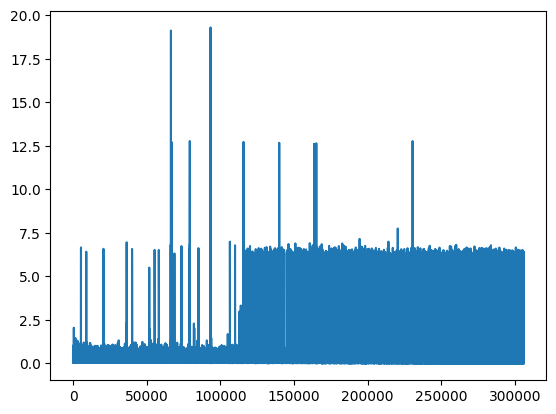

In [56]:
model = Red(n_entradas=27)
loss= nn.BCELoss()
optim=torch.optim.Adam(model.parameters(), lr=0.001)
v_err=[]
historico = pd.DataFrame()
accuracy_list = []
loss_list = []
for epoch in range(100):
  for data in enumerate(dataTrain):
    batch, (x,y)=data
    y_pred = model(x)
    y_pred_class = y_pred.round()
    optim.zero_grad()
    lo=loss(y_pred, y)
    correct = (y_pred_class == y).sum().item()
    accuracy = 100 * correct / float(len(y))
    accuracy_list.append(accuracy)
    loss_list.append(lo.item())
    if(batch % 4==0):
      print('Epoch: ',epoch,'Batch: ',batch, 'Error: ',lo.item())
    lo.backward()
    optim.step()
    v_err.append(lo.item())

  df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss':loss_list,
        'Accuracy': accuracy_list})
  historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)
plt.plot(v_err)

In [57]:
t_X_train = torch.from_numpy(X_train).float().to(device)
t_X_test = torch.from_numpy(X_test).float().to(device)
t_y_train = torch.from_numpy(y_train.values).float().to(device)
t_y_test = torch.from_numpy(y_test.values).float().to(device)
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]

In [58]:
y_train_pred_nn = model(t_X_train)

In [59]:
y_pred_train_nn = []
for i in y_train_pred_nn:
    y_pred_train_nn.append(round(i.item()))

In [60]:
y_train_list = y_train.values
y_train_list  = y_train_list.tolist()

In [61]:
confusion_matriz = confusion_matrix(y_train_list,y_pred_train_nn)
confusion_matriz

array([[40284,   598],
       [ 2331,  5747]], dtype=int64)

In [ ]:
print(classification_report(y_train, y_pred_train_nn))

In [62]:
y_test_pred_nn = model(t_X_test)
y_pred_test_nn = []
for i in y_test_pred_nn:
    y_pred_test_nn.append(round(i.item()))

In [63]:
y_test_list = y_test.values
y_test_list  = y_test_list.tolist()

In [64]:
confusion_matriz = confusion_matrix(y_test_list,y_pred_test_nn)
confusion_matriz

array([[9804,  495],
       [ 937, 1004]], dtype=int64)

In [65]:
print(classification_report(y_test, y_pred_test_nn))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10299
           1       0.67      0.52      0.58      1941

    accuracy                           0.88     12240
   macro avg       0.79      0.73      0.76     12240
weighted avg       0.87      0.88      0.88     12240

